# Embedded Machine Learning - Lab Exam Pipeline

This notebook provides a complete, reusable pipeline for a machine learning classification task, following the 5-question exam structure.

## 0. Setup and Imports

First, we import all the necessary libraries.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import ( 
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Configuration Block

**THIS IS THE ONLY CELL YOU NEED TO CHANGE FOR A NEW DATASET.**

Update `FILE_PATH`, `TARGET_COLUMN`, `DROP_COLUMNS`, `NUMERIC_FEATURES`, and `CATEGORICAL_FEATURES` to match your new dataset.

In [44]:
# --- CONFIGURATION FOR heart_failure_clinical_records_dataset.csv ---
FILE_PATH = 'heart_failure_clinical_records_dataset.csv'
TARGET_COLUMN = 'DEATH_EVENT'
DROP_COLUMNS = [] # No columns to drop for this dataset

# Features that are numeric/continuous
NUMERIC_FEATURES = [
    'age',
    'creatinine_phosphokinase',
    'ejection_fraction',
    'platelets',
    'serum_creatinine',
    'serum_sodium',
    'time'
]

# Features that are categorical/binary (even if 0/1)
CATEGORICAL_FEATURES = [
    'anaemia',
    'diabetes',
    'high_blood_pressure',
    'sex',
    'smoking'
]


# --- CONFIGURATION FOR kidney_disease.csv (Uncomment to use) ---
# NOTE: This dataset is famously messy. The configuration is more complex.

# FILE_PATH = 'kidney_disease.csv'
# TARGET_COLUMN = 'classification'
# DROP_COLUMNS = ['id'] # Drop the ID column

# # Features that *should be* numeric (even if stored as 'object')
# NUMERIC_FEATURES = [
#     'age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc'
# ]

# # Features that are categorical
# CATEGORICAL_FEATURES = [
#     'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'
# ]


print(f"--- Configuration Loaded ---")
print(f"File: {FILE_PATH}")
print(f"Target: {TARGET_COLUMN}")

--- Configuration Loaded ---
File: heart_failure_clinical_records_dataset.csv
Target: DEATH_EVENT


## Q1: Data Loading & Exploration (EDA)

In [45]:
# 1. Load Data
# We use na_values='?' because some CSVs (like kidney_disease) use '?' for missing.
try:
    df = pd.read_csv(FILE_PATH, na_values=['?', '\t?'])
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}")
    # Stop execution if file isn't found
    raise

# 2. Initial Cleaning
# Drop specified columns
if DROP_COLUMNS:
    df = df.drop(columns=DROP_COLUMNS)

# --- Data-Specific Type Coercion ---
# This block is crucial for messy datasets like kidney_disease

# Force numeric features to be numeric (errors become NaN)
for col in NUMERIC_FEATURES:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Numeric feature '{col}' not in DataFrame.")

# Force categorical features to be strings (and handle 'nan' as a string)
for col in CATEGORICAL_FEATURES:
    if col in df.columns:
        df[col] = df[col].astype(str).replace('nan', np.nan)
    else:
        print(f"Warning: Categorical feature '{col}' not in DataFrame.")

# --- Target Variable Cleaning ---
# Ensure target is 0/1 for classification
if TARGET_COLUMN in df.columns:
    if df[TARGET_COLUMN].dtype == 'object':
        print(f"Original target labels: {df[TARGET_COLUMN].unique()}")
        # Handle kidney_disease.csv specific case
        if FILE_PATH == 'kidney_disease.csv':
            df[TARGET_COLUMN] = df[TARGET_COLUMN].str.strip().map({'ckd': 1, 'notckd': 0})
            print("Mapped 'ckd' to 1 and 'notckd' to 0")
        else:
            # Simple binary mapping for other string targets
            try:
                labels = df[TARGET_COLUMN].dropna().unique()
                if len(labels) == 2:
                    df[TARGET_COLUMN] = df[TARGET_COLUMN].map({labels[0]: 0, labels[1]: 1})
                    print(f"Mapped '{labels[0]}' to 0 and '{labels[1]}' to 1")
            except Exception as e:
                print(f"Could not auto-map target: {e}")
    
    # Drop rows where target is NaN (critical after mapping)
    df = df.dropna(subset=[TARGET_COLUMN])
    df[TARGET_COLUMN] = df[TARGET_COLUMN].astype(int)
else:
    raise KeyError(f"Target column '{TARGET_COLUMN}' not found in the loaded data.")


# 3. Display Basic Info
print(f"\n--- Basic Information ---")
print(f"Data Shape: {df.shape}")
print(f"\nFeature Names: {df.columns.tolist()}")
print(f"\nTarget Variable: {TARGET_COLUMN}")

print("\n--- Data Types & Missing Values ---")
df.info()

print("\n--- Descriptive Statistics (Numeric) ---")
print(df.describe())


--- Basic Information ---
Data Shape: (299, 13)

Feature Names: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']

Target Variable: DEATH_EVENT

--- Data Types & Missing Values ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    object 
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    object 
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    object 
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium   


--- Target Variable Distribution (DEATH_EVENT) ---
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64


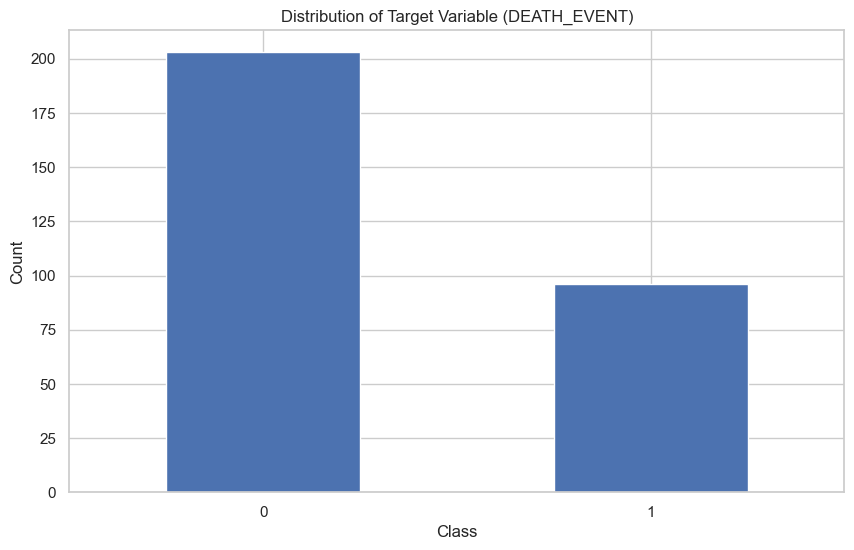

In [46]:
# 4. Visualize Distribution of Target Variable
print(f"\n--- Target Variable Distribution ({TARGET_COLUMN}) ---")
target_counts = df[TARGET_COLUMN].value_counts()
print(target_counts)

target_counts.plot(kind='bar', rot=0)
plt.title(f'Distribution of Target Variable ({TARGET_COLUMN})')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


--- Numeric Feature Distributions ---


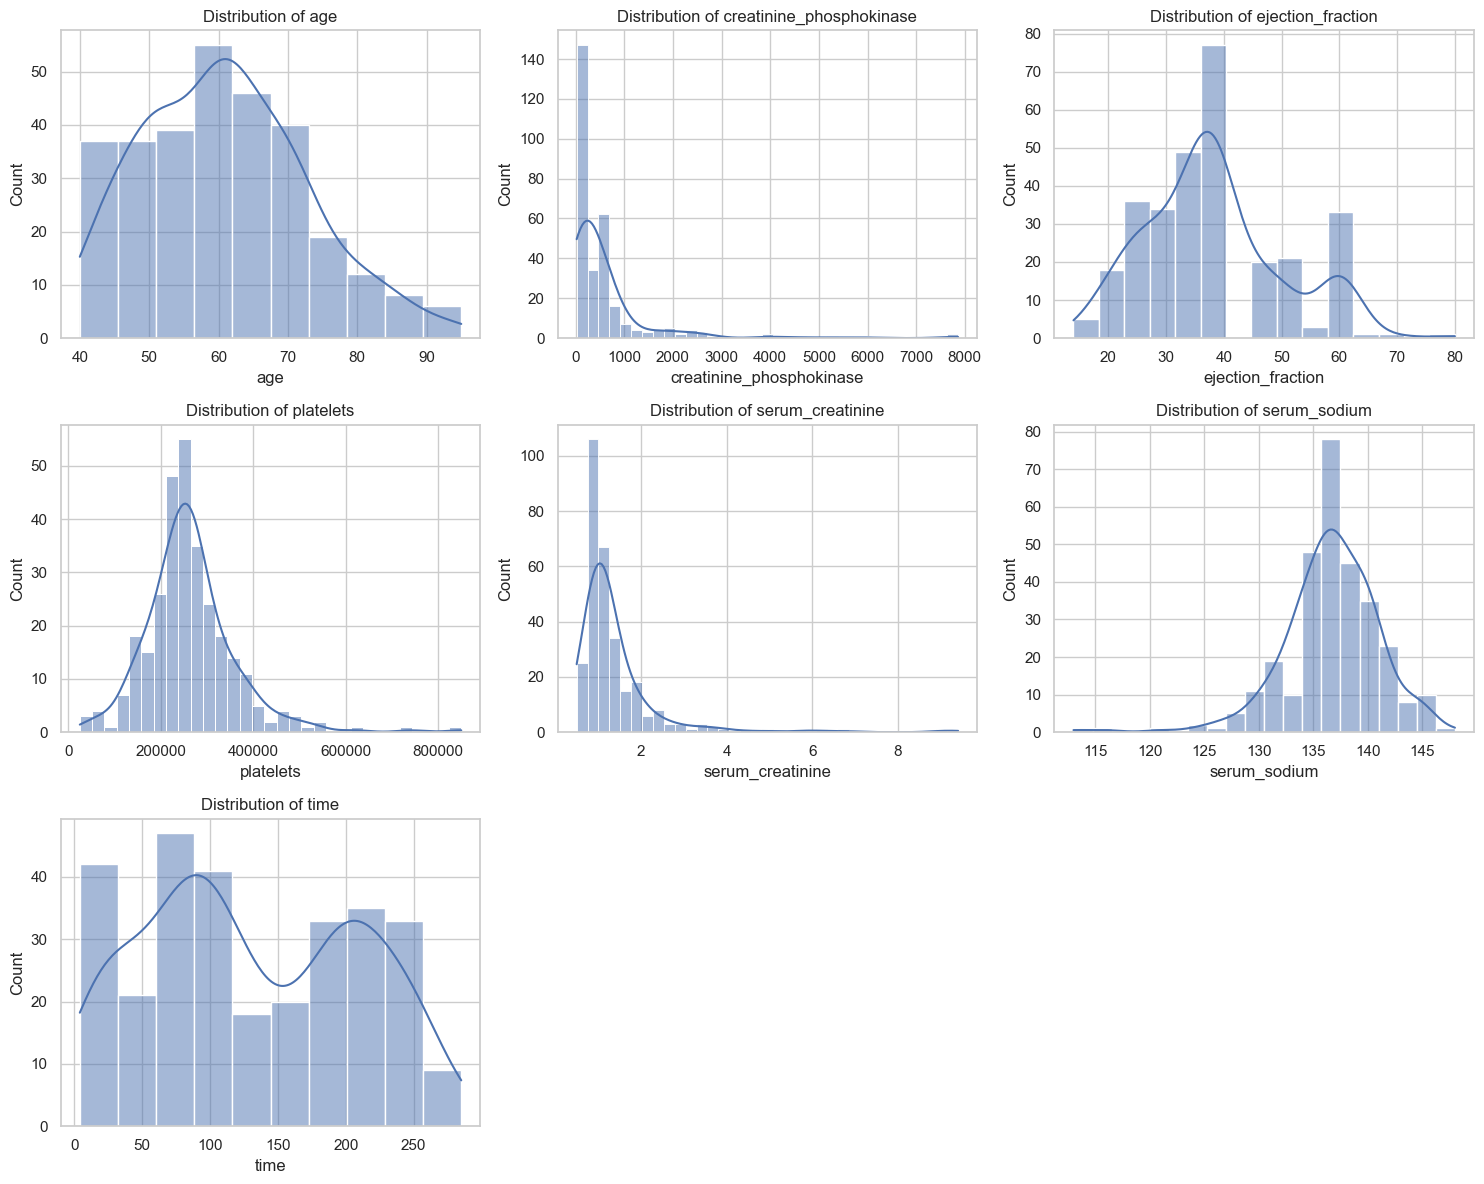

In [47]:
# 5. Visualize Distributions of Numeric Features
print("\n--- Numeric Feature Distributions ---")
n_cols = 3
n_rows = (len(NUMERIC_FEATURES) - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten() # Flatten to 1D array for easy iteration

for i, col in enumerate(NUMERIC_FEATURES):
    if col in df.columns:
        sns.histplot(df, x=col, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


--- Categorical Feature Distributions ---


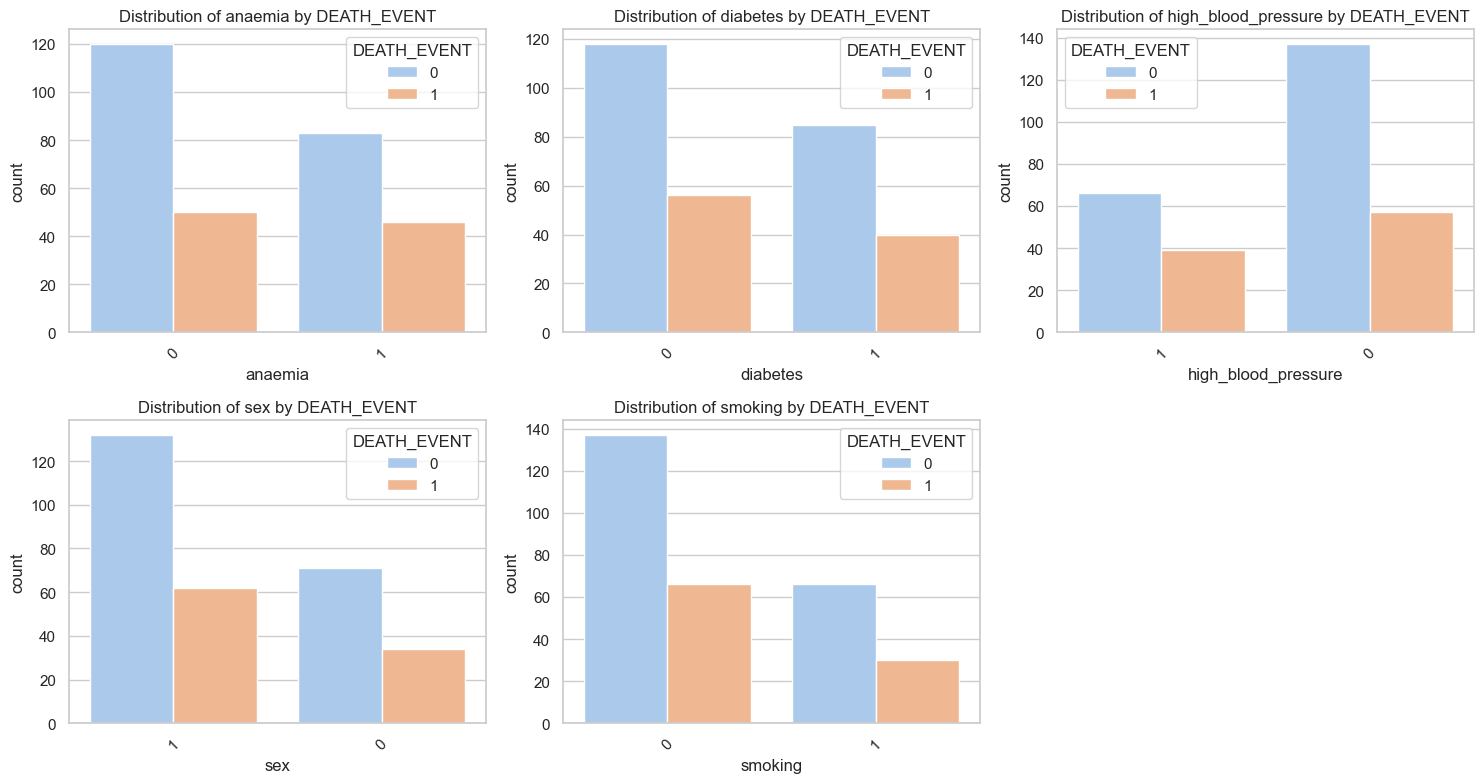

In [48]:
# 6. Visualize Distributions of Categorical Features
print("\n--- Categorical Feature Distributions ---")
n_cols = 3
n_rows = (len(CATEGORICAL_FEATURES) - 1) // n_cols + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(CATEGORICAL_FEATURES):
    if col in df.columns:
        # Use countplot, hue by target for extra insight
        sns.countplot(data=df, x=col, hue=TARGET_COLUMN, ax=axes[i], palette='pastel')
        axes[i].set_title(f'Distribution of {col} by {TARGET_COLUMN}')
        axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

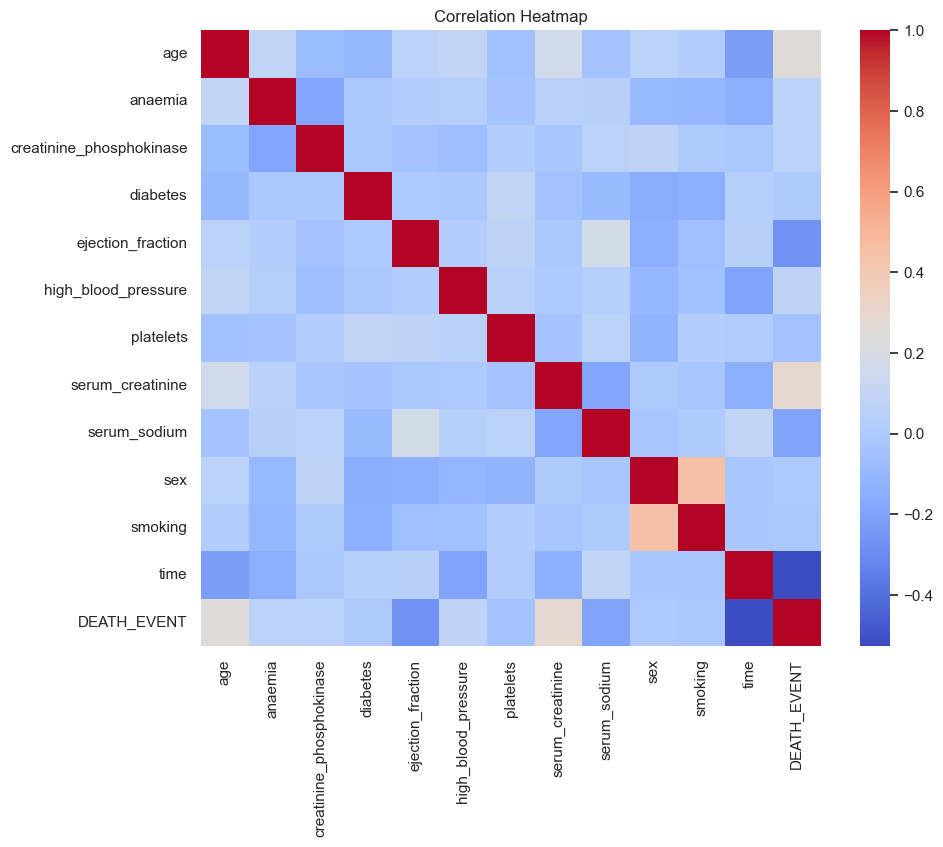

In [57]:
# ✅ Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Q2: Preprocessing & Feature Engineering

We will build a robust `ColumnTransformer` pipeline. This single object will:
1.  **Fill missing values (Impute):**
    * `numeric_features`: Use the 'median' (robust to outliers).
    * `categorical_features`: Use the 'most_frequent' value.
2.  **Remove Outliers:** We'll address this by using **median** imputation and **StandardScaler**, which are robust to outliers. Explicit outlier removal (like IQR) is a data-modifying step that can be complex. For an exam, relying on robust scalers and imputers is a safe strategy.
3.  **Apply Normalization:**
    * `numeric_features`: Use `StandardScaler` to scale data (mean=0, std=1).
4.  **Encode Categorical Variables:**
    * `categorical_features`: Use `OneHotEncoder` to convert them into numeric columns. `handle_unknown='ignore'` prevents errors on unseen test data.
5.  **Feature Selection:** We will perform feature selection *visually* in Q5 using feature importances from our trained models. This is a practical and effective method.

In [49]:
# 1. Define Features (X) and Target (y)
# Ensure only columns that exist in the *cleaned* df are used
all_features_in_df = NUMERIC_FEATURES + CATEGORICAL_FEATURES
features_to_use = [col for col in all_features_in_df if col in df.columns]

X = df[features_to_use]
y = df[TARGET_COLUMN]

# Update feature lists to only include columns that are actually in X
# This handles cases where a configured feature wasn't in the file
NUMERIC_FEATURES = [col for col in NUMERIC_FEATURES if col in X.columns]
CATEGORICAL_FEATURES = [col for col in CATEGORICAL_FEATURES if col in X.columns]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Using {len(NUMERIC_FEATURES)} numeric features: {NUMERIC_FEATURES}")
print(f"Using {len(CATEGORICAL_FEATURES)} categorical features: {CATEGORICAL_FEATURES}")

X shape: (299, 12)
y shape: (299,)
Using 7 numeric features: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
Using 5 categorical features: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']


In [50]:
# 2. Create Preprocessing Pipelines

# Pipeline for numeric features:
# 1. Impute missing values with the median (robust to outliers)
# 2. Scale features using StandardScaler (required for SVM, good for others)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features:
# 1. Impute missing values with the most frequent value
# 2. One-Hot Encode the features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ],
    remainder='passthrough' # Keep any columns not specified (should be none, but safe)
)

print("Preprocessing pipeline created successfully.")
print(preprocessor)

Preprocessing pipeline created successfully.
ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'creatinine_phosphokinase',
                                  'ejection_fraction', 'platelets',
                                  'serum_creatinine', 'serum_sodium', 'time']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['anaemia', 'diabetes', 'high_blood_pressure',
  

## Q3: Model Development & Evaluation

In [51]:
# 1. Training and Testing Partition
# We split the data *before* applying the preprocessor.
# The pipeline will handle applying transformations correctly (fit on train, transform on test).
# Use stratify=y to ensure class balance is maintained in splits, especially for imbalanced datasets.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,       # 30% for testing
    random_state=42,     # For reproducible results
    stratify=y           # Preserve class distribution
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (209, 12)
X_test shape: (90, 12)
y_train shape: (209,)
y_test shape: (90,)


In [52]:
# 2. Define Model Pipelines
# We create a full pipeline for each model, starting with our 'preprocessor'.
# This ensures all data transformations are part of the model itself.

models = {
    'Decision Tree': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    
    'SVM': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(random_state=42, probability=True)) # probability=True for potential ROC/AUC
    ])
}

print(f"Defined {len(models)} model pipelines.")

Defined 3 model pipelines.



Training Decision Tree...

--- Evaluation Metrics for Decision Tree ---
Accuracy: 0.7778
Precision: 0.6667
Recall: 0.6207
F1-Score: 0.6429

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84        61
           1       0.67      0.62      0.64        29

    accuracy                           0.78        90
   macro avg       0.75      0.74      0.74        90
weighted avg       0.77      0.78      0.78        90

Confusion Matrix:


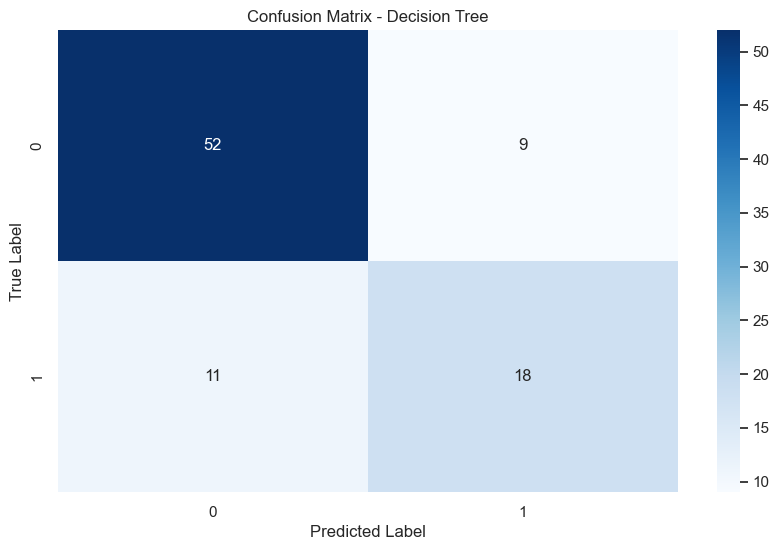


Training Random Forest...

--- Evaluation Metrics for Random Forest ---
Accuracy: 0.8333
Precision: 0.8500
Recall: 0.5862
F1-Score: 0.6939

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        61
           1       0.85      0.59      0.69        29

    accuracy                           0.83        90
   macro avg       0.84      0.77      0.79        90
weighted avg       0.84      0.83      0.82        90

Confusion Matrix:


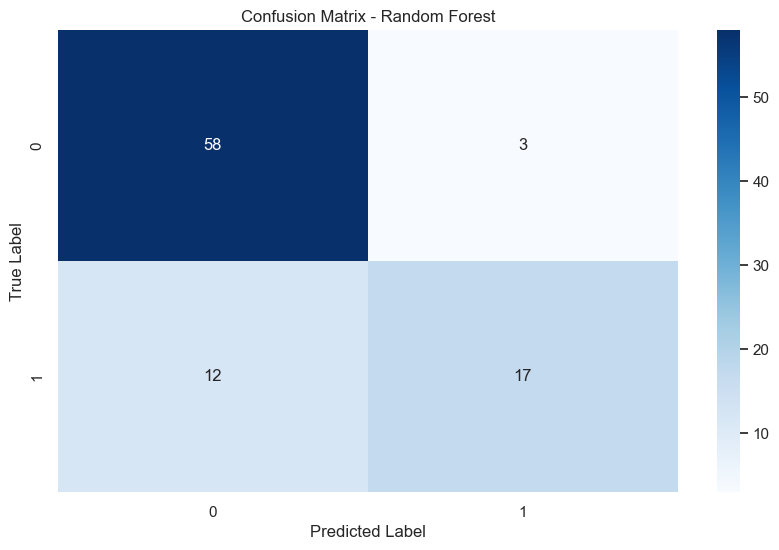


Training SVM...

--- Evaluation Metrics for SVM ---
Accuracy: 0.8000
Precision: 0.7200
Recall: 0.6207
F1-Score: 0.6667

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        61
           1       0.72      0.62      0.67        29

    accuracy                           0.80        90
   macro avg       0.78      0.75      0.76        90
weighted avg       0.80      0.80      0.80        90

Confusion Matrix:


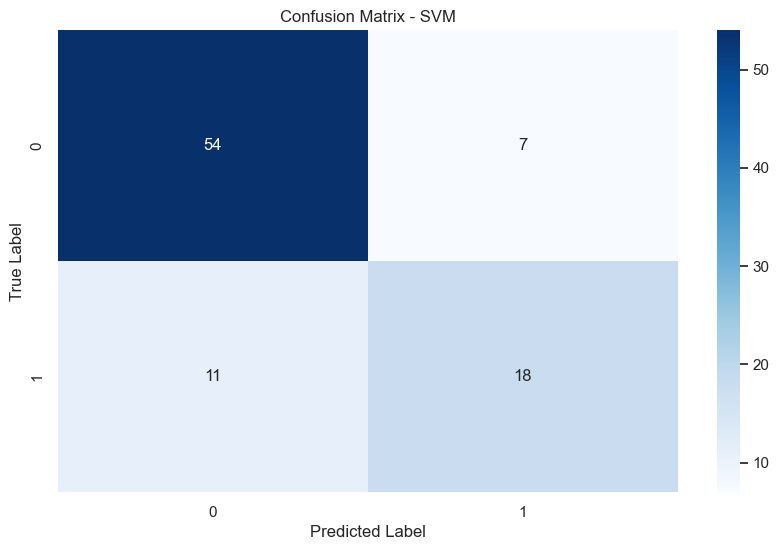

In [53]:
# 3. Train and Evaluate All Models

# We'll store the trained models in this dictionary
trained_models = {}

for name, model_pipeline in models.items():
    print(f"\n{'='*30}")
    print(f"Training {name}...")
    print(f"{'='*30}")
    
    # Train the model
    model_pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model_pipeline.predict(X_test)
    
    # --- Performance Evaluation ---
    print(f"\n--- Evaluation Metrics for {name} ---")
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Precision
    precision = precision_score(y_test, y_pred, zero_division=0)
    print(f"Precision: {precision:.4f}")
    
    # Recall
    recall = recall_score(y_test, y_pred, zero_division=0)
    print(f"Recall: {recall:.4f}")
    
    # F1-Score
    f1 = f1_score(y_test, y_pred, zero_division=0)
    print(f"F1-Score: {f1:.4f}")
    
    # Full Classification Report (includes all the above)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion Matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model_pipeline.classes_,
                yticklabels=model_pipeline.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Store the trained model
    trained_models[name] = model_pipeline

## Q4: Hyperparameter Tuning

We will select one model to tune. **Random Forest** is a good choice as it's powerful and less sensitive than SVM, but you could easily swap it for `'SVM'`.

We will use `GridSearchCV` to perform an exhaustive search over a specified parameter grid. For a faster (but less thorough) search, you could use `RandomizedSearchCV`.

**Explanation:**
* `GridSearchCV` systematically tests *every combination* of parameters you provide.
* `cv=5` means it uses 5-fold cross-validation. The training data is split into 5 parts; it trains on 4 and validates on 1, rotating 5 times.
* `scoring='f1'` (or `'accuracy'`) tells the search what metric to optimize for. `f1` is good for imbalanced classes.
* `n_jobs=-1` uses all available CPU cores to speed up the search.

In [54]:
# 1. Select Model and Define Parameter Grid

# We'll tune the Random Forest model
model_to_tune = trained_models['Random Forest']

# Define the parameter grid.
# NOTE: Parameter names MUST be prefixed with 'classifier__'
# This tells the pipeline to pass the parameter to the 'classifier' step.

# This is a SMALL grid for exam speed. You can add more values.
param_grid = {
    'classifier__n_estimators': [50, 100],          # Number of trees
    'classifier__max_depth': [10, None],              # Max depth of trees
    'classifier__min_samples_leaf': [1, 2, 4]         # Min samples at a leaf node
}

print("Starting Hyperparameter Tuning for Random Forest...")

# 2. Parameter Search (GridSearch CV)
# We use 'f1' as the scoring metric, which is often better for imbalanced classes.
# For the heart failure dataset, 'accuracy' is also fine.
grid_search = GridSearchCV(
    estimator=model_to_tune,
    param_grid=param_grid,
    cv=5,                  # 5-fold cross-validation
    n_jobs=-1,             # Use all CPU cores
    scoring='f1',          # Optimize for F1-score
    verbose=2              # Show progress
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

print("\nTuning complete.")

Starting Hyperparameter Tuning for Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Tuning complete.


Best parameters found: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 100}
Best F1-score from CV: 0.7666

--- Evaluation Metrics for Tuned Random Forest ---
Test Accuracy: 0.8444

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        61
           1       0.86      0.62      0.72        29

    accuracy                           0.84        90
   macro avg       0.85      0.79      0.81        90
weighted avg       0.85      0.84      0.84        90

Confusion Matrix (Test Set):


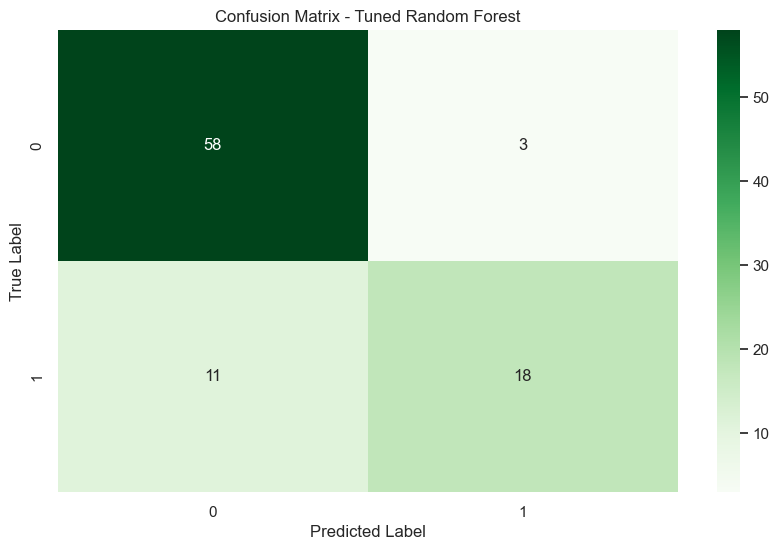

In [55]:
# 3. Select "Best" Parameters and Evaluate

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1-score from CV: {grid_search.best_score_:.4f}")

# Get the best model pipeline found by the search
best_model = grid_search.best_estimator_

# Store it for Q5
trained_models['Tuned Random Forest'] = best_model

# Evaluate this best model on the *test* set
print("\n--- Evaluation Metrics for Tuned Random Forest ---")
y_pred_best = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_best, zero_division=0))

print("Confusion Matrix (Test Set):")
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title('Confusion Matrix - Tuned Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Q5: Visualization & Insights / Interpretation


C:\Users\alvan\AppData\Local\Temp\ipykernel_16128\4164217649.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


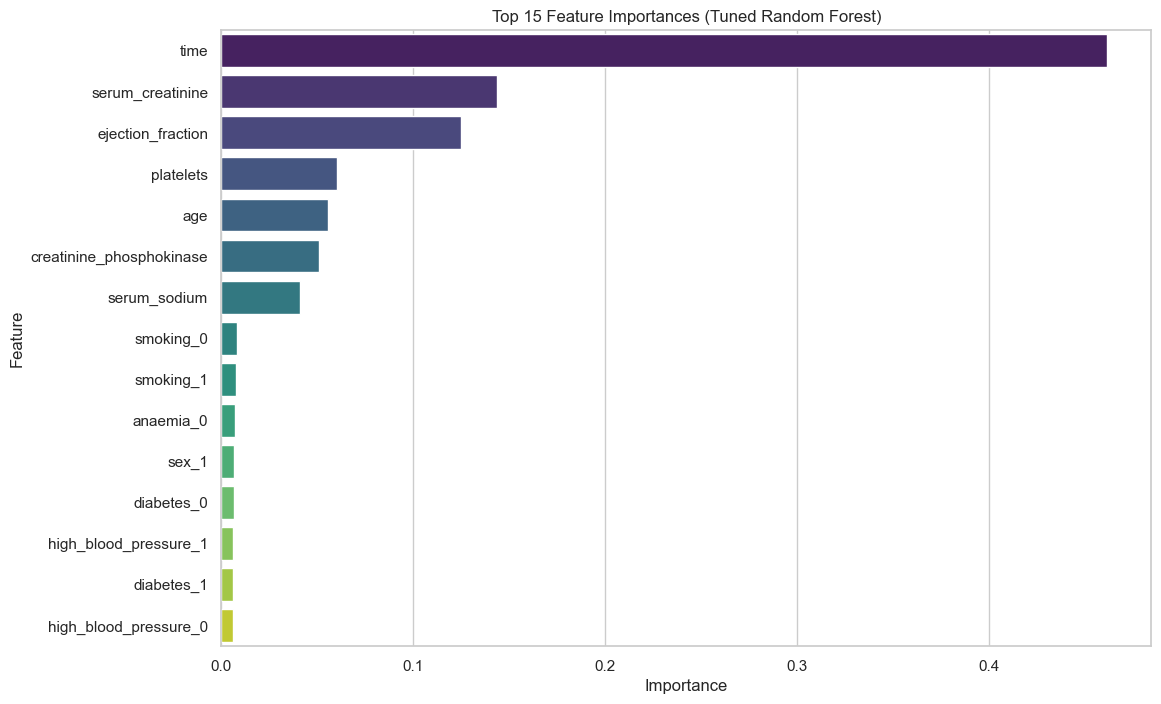

In [56]:
# 1. Plot Feature Importance
# We can get feature importances from tree-based models (DT, RF).
# Let's use our best-tuned Random Forest model.

try:
    # Get the preprocessor and classifier steps from the final pipeline
    preprocessor_step = best_model.named_steps['preprocessor']
    classifier_step = best_model.named_steps['classifier']

    # Get the feature names from the OneHotEncoder step
    # This is a bit complex but necessary
    ohe_transformer = preprocessor_step.named_transformers_['cat']
    ohe_feature_names = ohe_transformer.named_steps['onehot'].get_feature_names_out(CATEGORICAL_FEATURES)
    
    # Combine numeric and one-hot-encoded categorical feature names
    all_feature_names = NUMERIC_FEATURES + list(ohe_feature_names)
    
    # Get the importances from the classifier
    importances = classifier_step.feature_importances_
    
    # Create a DataFrame for easy plotting
    importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': importances
    })
    
    # Sort by importance and take the Top 15
    importance_df = importance_df.sort_values(by='importance', ascending=False).head(15)
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
    plt.title('Top 15 Feature Importances (Tuned Random Forest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

except Exception as e:
    print(f"Could not plot feature importance: {e}")
    print("This can happen with SVM or if the model steps are named differently.")

### 2. Data Storytelling & Insights

**(This is the template for your final written answer. Replace the brackets with your findings.)**

**1. The Problem:**
Our goal was to develop a model to predict `[e.g., patient mortality from heart failure OR presence of chronic kidney disease]` based on a dataset of clinical records.

**2. The Process:**
We built an end-to-end machine learning pipeline. This involved:
* **Loading & EDA:** Loading the data, identifying the target (`[Your Target]`), and visualizing feature distributions. We noted that `[e.g., the target class was imbalanced OR several features had missing data]`.
* **Preprocessing:** We created a robust pipeline to automatically handle missing values (using median/most_frequent), scale numeric features (using `StandardScaler`), and encode categorical features (using `OneHotEncoder`).
* **Modeling:** We trained and evaluated three baseline models: Decision Tree, Random Forest, and SVM. 

**3. Model Performance:**
Initially, the `[e.g., Random Forest]` model performed best, with a baseline accuracy of `[e.g., 0.85]`. The `[e.g., Decision Tree]` was simpler but less accurate, while the `[e.g., SVM]` had `[e.g., similar performance]`.

**4. Model Tuning & Selection:**
We selected the `Random Forest` model for hyperparameter tuning. Using `GridSearchCV`, we searched for the best combination of parameters (like `n_estimators` and `max_depth`). 

Our final, tuned model achieved a test accuracy of **`[e.g., 0.88]`** and an F1-score of **`[e.g., 0.87]`**. This model demonstrates `[e.g., strong predictive power]` on unseen data.

**5. Key Insights (Feature Importance):**
The feature importance plot reveals the most significant predictors. The top 3 most important features were:
1.  `[Top Feature 1]`
2.  `[Top Feature 2]`
3.  `[Top Feature 3]`

This indicates that `[e.g., 'time' (follow-up period) and 'serum_creatinine' levels]` are critical factors in determining patient outcomes. For an embedded system, while this Random Forest model is accurate, its size could be a concern. The simpler `Decision Tree` model, while less accurate (`[e.g., 0.82]`), is much smaller and faster, and could be a viable alternative if resource constraints are tight.